# 약물-단백질 상호작용

- 약물과 단백질의 상호작용 정도를 점수화한 데이터를 이용하여 상호작용을 예측하는 머신러닝 모델을 구현
- 약물과 단백질 데이터를 각각 입력으로 사용한다
    1. 약물의 특성과 단백질(타겟)의 특성을 각각 추출하는 모델 구성
    2. 추출된 특성을 **옆으로 붙인(concatenate)** 값을 만드고 이를 DTI 예측 모델 입력으로 사용한다
    3. 상호작용은 이진분류(0/1) 예측(확률) 또는 상호작용 점수 회귀 예측을 하게 된다.
- 약물 재창출 예제

- [DeepPurpose](https://deeppurpose.readthedocs.io/en/latest/notes/introduction.html) 모듈 사용
 - 약물-단백질 상호작용 예측 모델 구현 기능을 제공
 - 가상선별과 약물재창출을 위한 딥러닝 도구

In [1]:
!pip install pandas-flavor
!pip install git+https://github.com/bp-kelley/descriptastorus
!pip install DeepPurpose

  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-2gbug8a1
  Running command git clone --filter=blob:none --quiet https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-2gbug8a1
  Resolved https://github.com/bp-kelley/descriptastorus to commit 9b133e2c91bb6a67df53db4cba992776db219ab7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 23.1 MB/s eta 0:00:00
  Created wheel for descriptastorus: filename=descriptastorus-2.5.0.25-py3-none-any.whl size=1083539 sha256=64b880fe60b84eadf2260db593669d9819aad4ffd8963657d7a629b102df4ee8
  Stored in directory: /tmp/pip-ephem-wheel-cache-e03wny7a/wheels/b0/91/ea/7e8b56f17611c9bebc7f08065799bd317abd64f066463e2e8a
Successfully built descriptastorus
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached jedi-

# import

In [2]:
import torch
import DeepPurpose.DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *
import DeepPurpose.oneliner as oneliner
import numpy as np
import pickle

%config InlineBackend.figure_format = 'retina'

# 데이터(이진분류)

In [3]:
# binary 인자를 True로 선택하면 이진 분류 레이블을 사용
X_drug, X_target, y = load_process_DAVIS('./data/', binary=True)

# 화합물 데이터 확인
print("drug : ", X_drug[:3], end="\n\n")

# 타겟 단백질 데이터 확인
print("target : ",X_target[0], end="\n\n")

# 결합 여부 확인 (0이면 결합 안함, 1이면 결합)
print("Interaction : ",y[:3], end="\n\n")

Beginning Processing...
Beginning to extract zip file...
Default binary threshold for the binding affinity scores are 30, you can adjust it by using the "threshold" parameter
Done!
drug :  ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N'
 'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N'
 'CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']

target :  MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRR

In [4]:
# MLP 모델을 위한 encoding 방식 지정 (입력 특성으로 1차원 벡터를 사용)
drug_encoding = 'Morgan'
target_encoding = 'AAC'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random', frac=[0.8,0.1,0.1])
train[:3]

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68


[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerator
[08:45:30] DEPRECATION WARNING: please use MorganGenerat

encoding protein...
unique target sequence: 379
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
Done.


,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.221, 3.33, 3.434, 4.683, 1.353, 4.475, 11.6..."
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.483, 5.827, 3.599, 3.685, 1.028, 7.798, 3.0..."


# MLP 모델 사용

## 모델 정의 및 학습

In [5]:
# 모델 정의
config = generate_config(drug_encoding = drug_encoding, # encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 구조 정의
                         train_epoch = 100, # epoch 횟수
                         LR = 0.001, # 학습률 지정
                         batch_size = 256 # 배치사이즈 지정
                        )
model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Classifier(
  (model_drug): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=1024, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (model_protein): MLP(
    (predictor): ModuleList(
      (0): Linear(in_features=8420, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=64, bias=True)
      (3): Linear(in_features=64, out_features=256, bias=True)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)


Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69586. Total time 0.0 hours
Validation at Epoch 1, AUROC: 0.85839 , AUPRC: 0.29909 , F1: 0.22772 , Cross-entropy Loss: 1.87052
Training at Epoch 2 iteration 0 with loss 0.12244. Total time 0.00138 hours
Validation at Epoch 2, AUROC: 0.89034 , AUPRC: 0.36377 , F1: 0.16853 , Cross-entropy Loss: 1.77460
Training at Epoch 3 iteration 0 with loss 0.09106. Total time 0.00277 hours
Validation at Epoch 3, AUROC: 0.88318 , AUPRC: 0.34750 , F1: 0.13636 , Cross-entropy Loss: 1.82256
Training at Epoch 4 iteration 0 with loss 0.13408. Total time 0.00388 hours
Validation at Epoch 4, AUROC: 0.87966 , AUPRC: 0.38021 , F1: 0.15909 , Cross-entropy Loss: 1.77460
Training at Epoch 5 iteration 0 with loss 0.20246. Total time 0.005 hours
Validation at Epoch 5, AUROC: 0.88685 , AUPRC: 0.41275 , F1: 0.22702 , Cross-entropy Loss: 1.71465
Training at Epoch 6 iteration 0 with loss 0.12082. Total time 0.0

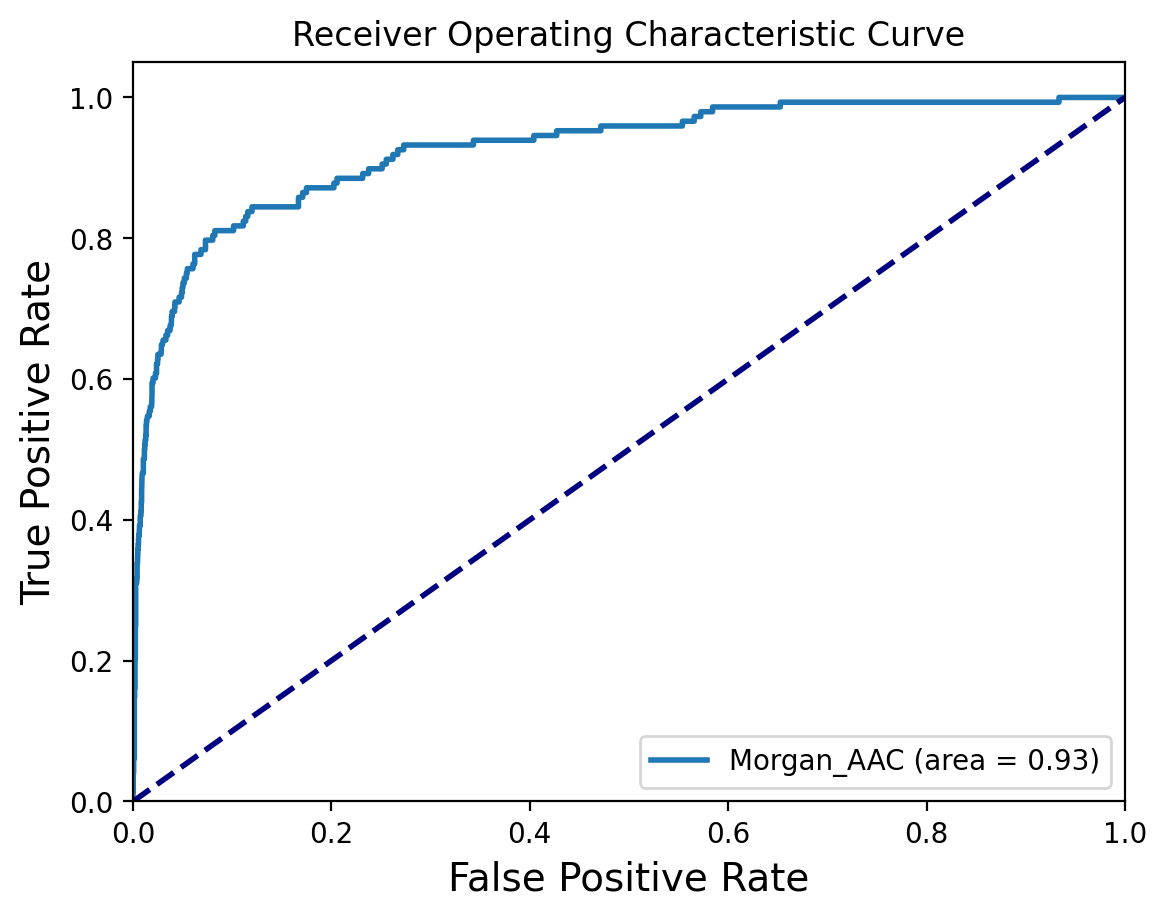

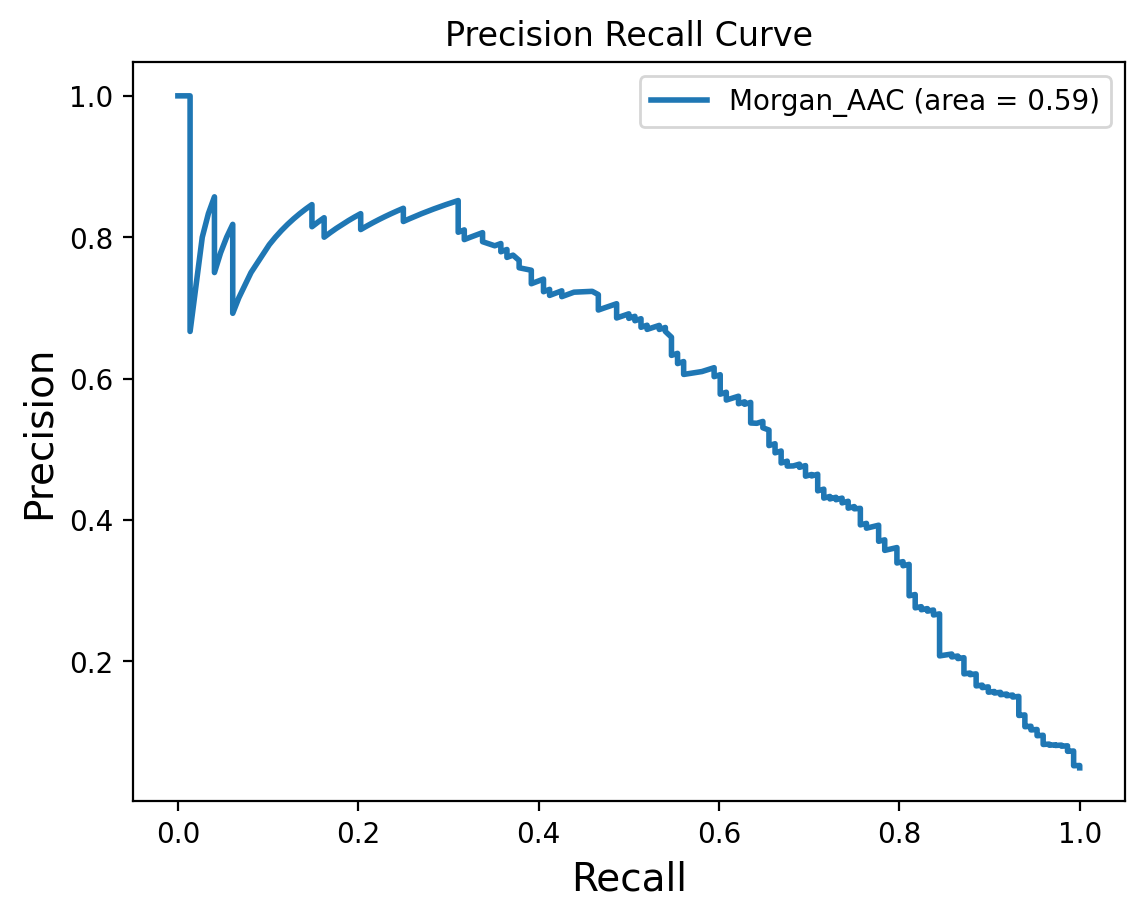

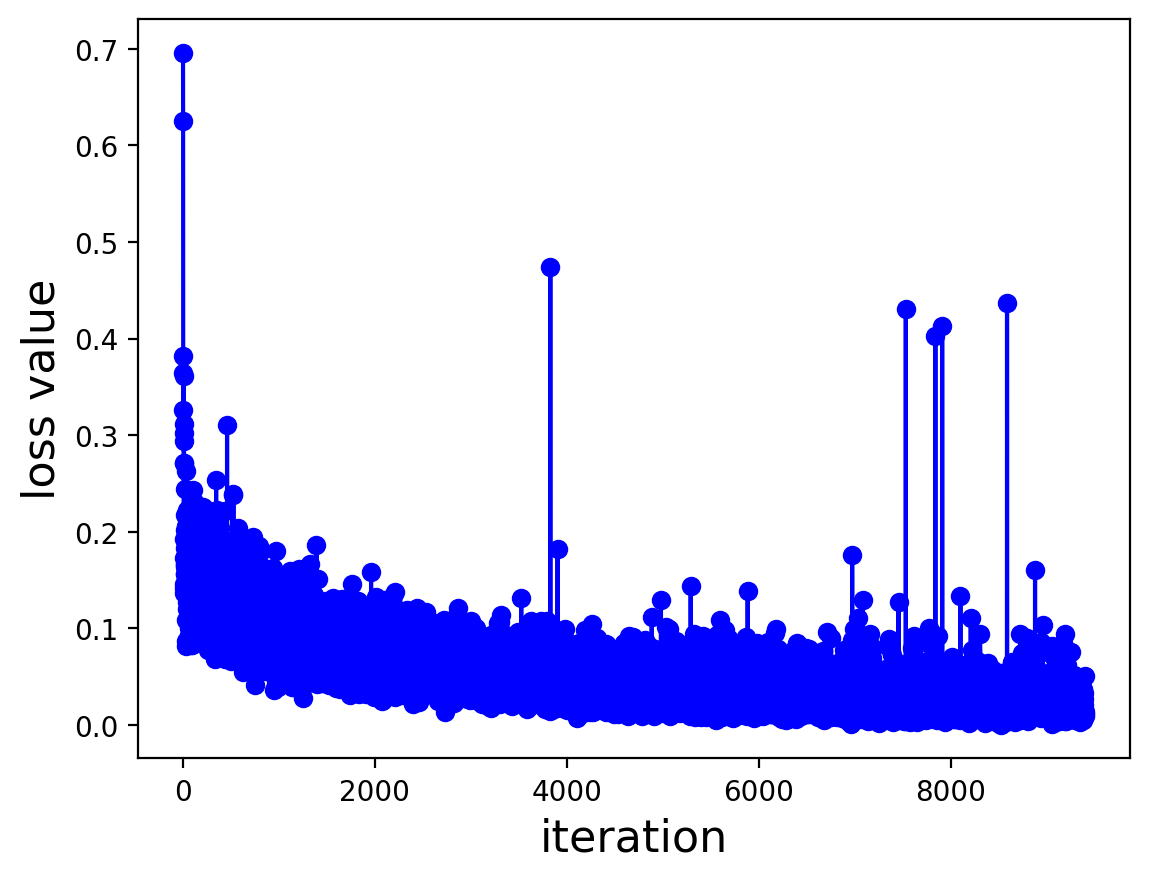

In [6]:
# 학습시간이 오래 걸린다 (11분)
model.train(train, val, test)

### 모델 저장

In [7]:
# 모델 저장 코드 (Morgan_AAC_model 폴더가 생성되며 그 안에 모델 가중치와 모델의 설정값이 저장됨)
model.save_model('./Morgan_AAC_model')

# CNN 모델 사용

## 모델 정의 및 학습

In [8]:
drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(drug_encoding = drug_encoding,# encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256, # 배치사이즈 지정
                         cnn_drug_filters = [32,64,96], # 약물 레이어의 cnn 필터 개수 지정
                         cnn_target_filters = [32,64,96], # 타겟 레이어의 cnn 핕터 개수 지정
                         cnn_drug_kernels = [4,6,8], # 약물 레이어의 커널 사이즈 지정
                         cnn_target_kernels = [4,8,12] # 타겟 레이어의 커널 사이즈 지정
                        )

model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_feat

In [9]:
# CNN 모델 사용

## 모델 정의 및 학습

drug_encoding = 'CNN'
target_encoding = 'CNN'
train, val, test = data_process(X_drug, X_target, y,
                                drug_encoding, target_encoding,
                                split_method='random',frac=[0.8,0.1,0.1])


config = generate_config(drug_encoding = drug_encoding,# encoding 옵션에 따라 모델 레이어가 설정됨
                         target_encoding = target_encoding,
                         cls_hidden_dims = [1024,1024,512], # 모델 말단의 예측 레이어의 구조 정의
                         train_epoch = 100, # 모델 학습 시 반복 횟수 지정
                         LR = 0.001, # 학습률 지정
                         batch_size = 256, # 배치사이즈 지정
                         cnn_drug_filters = [32,64,96], # 약물 레이어의 cnn 필터 개수 지정
                         cnn_target_filters = [32,64,96], # 타겟 레이어의 cnn 핕터 개수 지정
                         cnn_drug_kernels = [4,6,8], # 약물 레이어의 커널 사이즈 지정
                         cnn_target_kernels = [4,8,12] # 타겟 레이어의 커널 사이즈 지정
                        )

model = models.model_initialize(**config)
# 모델 구조 보기
print(model.model)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Classifier(
  (model_drug): CNN(
    (conv): ModuleList(
      (0): Conv1d(63, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(6,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (model_protein): CNN(
    (conv): ModuleList(
      (0): Conv1d(26, 32, kernel_size=(4,), stride=(1,))
      (1): Conv1d(32, 64, kernel_size=(8,), stride=(1,))
      (2): Conv1d(64, 96, kernel_size=(12,), stride=(1,))
    )
    (fc1): Linear(in_features=96, out_features=256, bias=True)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (predictor): ModuleList(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
    (2): Linear(in_feat

In [10]:
# 시간이 오래 걸린다
# model.train(train, val, test)

# (참고) 약물 재창출

- drug repurposing
- 기존의 FDA허가 약물에 대해서 다른 질병(단백질)에 대한 효과를 예측
- DeepPurpose에서 제공하는 사전 학습된 DTI 모델을 사용한다
 - 다른 타겟 질병(단백질)과 기존의 허가 약물을 입력으로 넣어 상호작용을 예측

## 코로나 바이러스와 기존 약물의 결합을 예측

In [11]:
target, target_name = load_SARS_CoV_Protease_3CL() # SARS-CoV: 코로나바이러스
drug, drug_names = load_antiviral_drugs('./data', no_cid = True) # 항 바이러스 약물 데이터셋

### 데이터 확인

In [12]:
print('target_name :\t', target_name)
print('target :\t', target[:100], '...')
print('drug_names :\t', drug_names[:3], '...')
print('drug :\t\t', drug[:3], '...')

target_name :	 SARS-CoV 3CL Protease
target :	 SGFKKLVSPSSAVEKCIVSVSYRGNNLNGLWLGDSIYCPRHVLGKFSGDQWGDVLNLANNHEFEVVTQNGVTLNVVSRRLKGAVLILQTAVANAETPKYK ...
drug_names :	 ['Abacavir' 'Aciclovir' 'Adefovir'] ...
drug :		 ['C1CC1NC2=C3C(=NC(=N2)N)N(C=N3)C4CC(C=C4)CO'
 'C1=NC2=C(N1COCCO)NC(=NC2=O)N' 'C1=NC(=C2C(=N1)N(C=N2)CCOCP(=O)(O)O)N'] ...


### 결합도 예측
- 사전학습 모델의 경로를 입력하지 않으면 DeepPurpose에서 제공하는 사전학습 모델이 사용됨

In [13]:
import DeepPurpose.oneliner as oneliner

oneliner.repurpose(*load_SARS_CoV2_Protease_3CL(), *load_antiviral_drugs(no_cid = True))

Save path not found or given and set to default: './save_folder/'. 
Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
pretrained model Successfully Downloaded...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

---------------
Predictions from model 3 with drug encoding Morgan and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

Done.
predicting...
---------------
Predictions from model 4 with drug encoding Morgan and target encoding AAC are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
Done.
predicting...
---------------
Predictions from model 5 with drug encoding Daylight and target encoding AAC are done...
-------------
models prediction finished...
aggregating results...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |    Fosamprenavir     | SARS-CoV2 3CL Protease |     119.12    |
|  2   |      Vicriviroc      | SARS-CoV2 3CL Protease |     198.96    |
|  3   |     Daclatasvir      | SARS-CoV2 3CL Protease |     303.23    |
|  4   |      Darunavir       | SARS-CoV2 3CL Protease |     369.04    |
|  5   |      Lopin

### 약물 이름의 index를 찾아 약물 데이터 확인

In [14]:
target_name = 'Fosamprenavir'
print('drug name : ', target_name)
print('drug index : ', np.where(drug_names == target_name)[0][0])
print('drug smiles : ', drug[31])

drug name :  Fosamprenavir
drug index :  31
drug smiles :  CC(C)CN(CC(C(CC1=CC=CC=C1)NC(=O)OC2CCOC2)OP(=O)(O)O)S(=O)(=O)C3=CC=C(C=C3)N


### COCONUT 데이터 상호작용 예측

In [15]:
# coconut database 다운로드 후 파일 압축 해제 및 파일명 확인
! wget https://coconut.s3.uni-jena.de/prod/downloads/2024-09/coconut-09-2024.csv.zip
!unzip ./coconut-09-2024.csv.zip

--2024-09-23 08:54:46--  https://coconut.s3.uni-jena.de/prod/downloads/2024-09/coconut-09-2024.csv.zip
Resolving coconut.s3.uni-jena.de (coconut.s3.uni-jena.de)... 141.35.104.25, 141.35.104.26, 2001:638:1558:2368::8d23:681a, ...
Connecting to coconut.s3.uni-jena.de (coconut.s3.uni-jena.de)|141.35.104.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88935618 (85M) [application/zip]
Saving to: ‘coconut-09-2024.csv.zip’

coconut-09-2024.csv 100%[===================>]  84.82M  21.0MB/s    in 5.1s    

2024-09-23 08:54:51 (16.5 MB/s) - ‘coconut-09-2024.csv.zip’ saved [88935618/88935618]

Archive:  ./coconut-09-2024.csv.zip
  inflating: coconut-09-2024.csv     
  inflating: __MACOSX/._coconut-09-2024.csv  


In [16]:
coconut = pd.read_csv('./coconut-09-2024.csv')
coconut

,standard_inchi,standard_inchi_key,canonical_smiles,identifier
0,InChI=1S/C43H53N9O14S2.Na/c1-5-22(3)35-36(57)4...,DRKUXFLLRIKRHH-QDVYGYDXSA-M,CC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)CNC(...,CNP0437004.1
1,InChI=1S/C21H32O12/c1-9-14(23)16(25)18(27)21(3...,OXHVQSRYUNGYOK-NUASCYGXSA-N,COC1=CC=C(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)...,CNP0243002.1
2,InChI=1S/C36H61N5O7/c1-21(2)18-27-35(47)48-28(...,NEGZFRNAAJQQEG-NOFCQABOSA-N,C/C1=C\[C@@H](C(C)(C)C)OC(=O)[C@H](CC(C)C)N(C)...,CNP0458114.1
3,InChI=1S/C22H22O9/c1-28-12-4-2-11(3-5-12)15-9-...,DQIVYFNWBDHNFD-WHCFWRGISA-N,COC1=CC=C(C2=CC(=O)OC3=CC(O[C@@H]4O[C@H](CO)[C...,CNP0252086.2
4,InChI=1S/C32H41N5O4/c1-6-18(4)28-32(41)36-12-8...,HKVSEIVDIONNKB-QWNGKRCASA-N,CC[C@H](C)[C@H]1C(=O)N2CCC[C@H]2C(=O)N1C(=O)[C...,CNP0107934.1
...,...,...,...,...
695128,InChI=1S/C19H19N3O4/c1-26-13-8-6-12(7-9-13)20-...,HHSNDFVMRMIDBG-INIZCTEOSA-N,COC1=CC=C(NC(=O)CC[C@@H]2NC(=O)C3=CC=CC=C3NC2=...,CNP0395779.1
695129,InChI=1S/C30H30N2O10/c1-12-23(34)27(38)28(39)3...,VVPODVCQSZKNKL-RLOKSPFPSA-N,CC(=O)OC1=CC=C2C(=O)C3=C(O)C(CC4=CC=CC(C(N)N)=...,CNP0097600.1
695130,InChI=1S/C21H22O7/c1-11(2)4-5-13-15(23)7-6-14(...,LMFCHRAKSGPODM-OAQYLSRUSA-N,COC1=C([C@]2(O)COC3=CC(O)=CC(O)=C3C2=O)C=CC(O)...,CNP0212403.1
695131,InChI=1S/C20H30O7/c1-17(2)4-3-12(23)18-8-27-20...,IJWNAKYUVUUYTE-HMBONYETSA-N,CC1(C)CC[C@H](O)[C@]23COC(O)([C@@H](O)[C@H]12)...,CNP0494455.1


In [17]:
# SMILES와 cid를 저장할 리스트 생성
coconut_smiles = list(coconut['canonical_smiles'])
coconut_cid = list(coconut['identifier'])

print('cid_names :\t', coconut_cid[:3])
print('smiles :\t\t', coconut_smiles[:3])
print('cid_len :\t', len(coconut_cid))
print('smiles_len :\t', len(coconut_smiles))

cid_names :	 ['CNP0437004.1', 'CNP0243002.1', 'CNP0458114.1']
smiles :		 ['CC[C@@H]1NC(=O)[C@@H](NC(=O)[C@H](C)NC(=O)CNC(=O)C2=CC=C(O)C=C2)CNC(=O)[C@H](CS(=O)(=O)[O-])NC(=O)/C=C/C2=CSC(=N2)[C@H](CC2=CC=C(O)C=C2)NC(=O)C(=O)[C@H]([C@@H](C)CC)NC1=O.[Na+]', 'COC1=CC=C(CCO[C@@H]2O[C@H](CO[C@@H]3O[C@@H](C)[C@H](O)[C@@H](O)[C@H]3O)[C@@H](O)[C@H](O)[C@H]2O)C=C1O', 'C/C1=C\\[C@@H](C(C)(C)C)OC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H](C)N(C)C(=O)CNC(=O)[C@H](C(C)C)NC(=O)[C@@H]2CCCN2C(=O)[C@H](C)CC1']
cid_len :	 695133
smiles_len :	 695133


In [18]:
oneliner.repurpose(target = target,
                    target_name = target_name,
                    X_repurpose = coconut_smiles[:10000],
                    drug_names = coconut_cid[:10000],
                    save_dir = './save_folder',
                    )

Loading customized repurposing dataset...
Beginning Downloading Pretrained Model...
Note: if you have already download the pretrained model before, please stop the program and set the input parameter 'pretrained_dir' to the path
Dataset already downloaded in the local system...
Using pretrained model and making predictions...
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 1 with drug encoding MPNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 2 with drug encoding CNN and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATION WARNING: please use MorganGenerator
[08:56:56] DEPRECATI

encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Predictions from model 3 with drug encoding Morgan and target encoding CNN are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATION WARNING: please use MorganGenerator
[08:57:26] DEPRECATI

encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
Done.
predicting...
---------------
Predictions from model 4 with drug encoding Morgan and target encoding AAC are done...
-------------
repurposing...
Drug Target Interaction Prediction Mode...
in total: 10000 drug-target pairs
encoding drug...
unique drugs: 10000


/usr/local/lib/python3.10/dist-packages/DeepPurpose/DTI.py:588: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(path, map_location = torch.device('cpu'

rdkit not found this smiles: [Os] convert to all 0 features
rdkit not found this smiles: [Ar] convert to all 0 features


[08:57:55] WARNING: not removing hydrogen atom without neighbors


rdkit not found this smiles: [HH] convert to all 0 features
rdkit not found this smiles: [123IH] convert to all 0 features
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
Done.
predicting...
---------------
Predictions from model 5 with drug encoding Daylight and target encoding AAC are done...
-------------
models prediction finished...
aggregating results...
---------------
Drug Repurposing Result for Fosamprenavir
+-------+---------------+---------------+---------------+
|  Rank |   Drug Name   |  Target Name  | Binding Score |
+-------+---------------+---------------+---------------+
|   1   |  CNP0277099.3 | Fosamprenavir |      1.17     |
|   2   |  CNP0327082.2 | Fosamprenavir |      2.18     |
|   3   |  CNP0211026.2 | Fosamprenavir |      2.62     |
|   4   |  CNP0384013.2 | Fosamprenavir |      3.06     |
|   5   | 